# Detecting shape of object in images

This notebook covers using Microsoft CNTK to detect shape of an object in an image. We will use a CNN for this purpose.Please read through [CNTK_103D](http://cntk.ai/pythondocs/CNTK_103D_MNIST_ConvolutionalNeuralNetwork.html) tutuorial to understand the basics of building a CNN using CNTK. 

The dataset used is synthetically generated. Please see [gen-image-dataset-with-shapes.ipynb](http://github.com/milangada/multimedia-ml/blob/master/gen-image-dataset-with-shapes.ipynb) for how the data is generated

In [2]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import cntk as C

%matplotlib inline

from cntk.io import UserMinibatchSource, StreamInformation, MinibatchData, Value
from PIL import Image



# Ensure we always get the same amount of randomness
np.random.seed(0)



### Global variables

Define the global variables

In [3]:
# Define the data dimensions
global input_dim_model 
global input_dim
global num_output_classes

global cx 
global cy 
global cz

global plotdata

### Helper function to initialize global variables

A helper function to initialize the global variables

In [4]:
def initializeVariables(channels, outputs, width, height):
    global input_dim_model, input_dim, num_output_classes, cx, cy, plotdata
    
    input_dim_model = (channels, width, height)
    
    input_dim = channels * width * height
    num_output_classes = outputs
    
    cx = C.input_variable(input_dim_model)
    cy = C.input_variable(num_output_classes)
    
    plotdata = {"minibatch_num":[], "loss":[], "error":[], "time":[]}

### A class for reading images in batches

This is not covered in the CNTK CNN tutorial. Here we define a class that inherits from "UserMinibatchSource". The purpose of this class is to serve as the source of data for images (and the corresponding labels) read in batches. An alternative is to use the CNTK provided image deserializer class (ImageDeserializer) but this gives us more control on how the data is read and will be useful in future work

In [5]:
class ImgDataSource(UserMinibatchSource):
    def __init__(self, idx_filename, f_dim, l_dim):
        
        self.f_dim, self.l_dim = f_dim, l_dim
        
        
        self.fsi = StreamInformation("features", 0, 'dense', np.float32, (self.f_dim,))
        self.lsi = StreamInformation("labels", 1, 'dense', np.float32, (self.l_dim,))
        
        self.data = {}
        self.datafiles = []
        
        if not os.path.isfile(idx_filename):
            print("Index file " + idx_filename + " not found")
            return
        else:
            # Read the index file
            
            f = open(idx_filename, "r")
            
            lines = f.readlines()
            for x in lines:
                x = x.strip()
                imgfile, imglabel = x.split('\t', 1)
                
                self.datafiles.append([imgfile, int(imglabel)])
            f.close()
            
        self.next_seq_idx = 0
        
        # Create a matrix to represent the one-hot labels corresponding to the outputs
        self.label_onehot = np.eye(num_output_classes, dtype=int)
        
        super(ImgDataSource, self).__init__()

    def stream_infos(self):
        return [self.fsi, self.lsi]

    def next_minibatch(self, num_samples, number_of_workers=1, worker_rank=0, device=None):
        # Note that in this example we do not yet make use of number_of_workers or
        # worker_rank, which will limit the minibatch source to single GPU / single node
        # scenarios.

        features = []
        labels = []

        sweep_end = False

        sample_count = 0
        
        while (sample_count < num_samples):
            if self.next_seq_idx == len(self.datafiles):
                sweep_end = True
                self.next_seq_idx = 0
            
            img = Image.open(self.datafiles[self.next_seq_idx][0])
            
            # Convert Image to numpy array. 
            f_data = np.array(img)
          
             
            if (len(f_data.shape) == 2):
                # Image has shape height x width. We need to transpose it to width x height
                f_data = f_data.transpose(1, 0)    
                
                # This extra step is required to create data in the right shape that is acceptable during the training process.
                # Ignoring this step will result in an error. Try commenting out the line below and observe the error.                
                f_data = f_data[None, :]
            elif (len(f_data.shape) == 3):
                # Image has shape height x width x channel. We need to transpose it to channel x width x height            
                f_data = f_data.transpose(2, 1, 0)
            else:
                print("Unexpected image type")
                return -1
                        
            #Assign the one-hot encoded label to l_data
            l_data = self.label_onehot[self.datafiles[self.next_seq_idx][1]]
            
            features.append(f_data)
            labels.append(l_data)
                        
            sample_count = sample_count + 1
            self.next_seq_idx = self.next_seq_idx + 1
            
        num_seq = len(features)
                               
        f_data = Value(batch=np.asarray(features, dtype=np.float32))
        l_data = Value(batch=np.asarray(labels, dtype=np.float32))    
        
        result = {            
                cx: MinibatchData(f_data, num_seq, sample_count, sweep_end),
                cy: MinibatchData(l_data, num_seq, sample_count, sweep_end)
                }
   

        return result        

### Helper function to create reader
Below is a simple helper function to help create the custom minibatch data source for images

In [6]:
def create_reader(idx_filepath, input_dim, num_label_classes):
    
    return ImgDataSource(idx_filepath, input_dim, num_label_classes)    

### More helper functions

The functions below are copied from [CNTK_103D](http://cntk.ai/pythondocs/CNTK_103D_MNIST_ConvolutionalNeuralNetwork.html) tutorial (read that tutorial for a better understanding of what they do)

In [7]:
# function to build model

def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
            h = features
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=8, 
                                       strides=(2,2), 
                                       pad=True, name='first_conv')(h)
            h = C.layers.MaxPooling(filter_shape=(2,2), 
                                    strides=(2,2), name="first_max")(h)            
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(2,2), 
                                       pad=True, name='second_conv')(h)
            h = C.layers.MaxPooling(filter_shape=(3,3), 
                                    strides=(3,3), name="second_max")(h)            
            r = C.layers.Dense(num_output_classes, activation=None, name='classify')(h)
            return r

In [8]:
def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss, errs # (model, labels) -> (loss, error metric)

In [9]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, start_time, verbose=1):
    training_loss = "NA"
    eval_error = "NA"
    time_since_start = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        time_since_start = "{:.1f}".format(time.time() - start_time)
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100) + ", Time since start: " + time_since_start)
        
    return mb, training_loss, eval_error, time_since_start

### Function to train CNN based on provided training dataset

The function below goes through the cycle of training the CNN

In [27]:
def img_train(train_reader, model_func, train_minibatch_size = 35, num_samples_per_sweep = 15000, 
              num_sweeps_to_train_with = 10, learning_rate = 0.1, training_progress_output_freq = 500):
    
    global plotdata
    
    print("Training minibatch size = " + str(train_minibatch_size))
    print("Number of samples per sweep = " + str(num_samples_per_sweep))
    print("Number of sweeps to train with = " + str(num_sweeps_to_train_with))
    print("Learning rate = " + str(learning_rate))
    
    
    # Instantiate the model function; x is the input (feature) variable 
    # We will scale the input image pixels within 0-1 range by dividing all input value by 255.
    model = model_func(cx/255)
    
    # Instantiate the loss and error function
    loss, label_error = create_criterion_function(model, cy)
    
    # Instantiate the trainer object to drive the model training
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner = C.sgd(cz.parameters, lr_schedule)
    trainer = C.Trainer(cz, (loss, label_error), [learner])
    
    # Initialize the parameters for the trainer
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / train_minibatch_size
           
    # Start a timer
    start = time.time()
    
    print("Number of mini batches to train = " + str(num_minibatches_to_train))
    
    for i in range(0, int(num_minibatches_to_train)):
        # Read a mini batch from the training dataset
        data=train_reader.next_minibatch(train_minibatch_size)
        
        trainer.train_minibatch(data)
        mb, training_loss, eval_error, time_since_start = print_training_progress(trainer, i, 
                                                                                  training_progress_output_freq, start, 
                                                                                  verbose=1)
        
        if ((i % training_progress_output_freq) == 0):
            plotdata["minibatch_num"].append(mb)
            plotdata["loss"].append(training_loss)
            plotdata["error"].append(eval_error)
            plotdata["time"].append(time_since_start)
     
    # Print training time
    print("Training took {:.1f} sec".format(time.time() - start))
    
    return trainer
    

### Function to test the trained CNN

The function below goes through the cycle of testing the CNN

In [11]:
def img_test(trainer, test_reader, num_test_samples = 3000, test_minibatch_size = 50, print_frequency = 500):
    
    # Test data for trained model       
    num_minibatches_to_test = num_test_samples // test_minibatch_size

    print("Number of minibatches to test = " + str(num_minibatches_to_test))
    test_result = 0.0   

    for i in range(0, num_minibatches_to_test):               
        # We are loading test data in batches specified by test_minibatch_size
        data = test_reader.next_minibatch(test_minibatch_size)
            
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error
        
        if ((i % print_frequency) == 0):
            print("Testing minibatch " + str(i) + " Eval error = " + str(eval_error))

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result * 100 / num_minibatches_to_test))    

Helper function to create readers and trigger training and testing

In [19]:
def train_and_test(train_file, test_file, train_minibatch_size = 35, num_samples_per_sweep = 15000, 
                   num_sweeps_to_train_with = 10, learning_rate = 0.1,):
    global cz
    
    cz = create_model(cx)
    reader_train = create_reader(train_file, input_dim, num_output_classes)
    reader_test = create_reader(test_file, input_dim, num_output_classes)
    trainer = img_train(reader_train, cz, train_minibatch_size, num_samples_per_sweep, num_sweeps_to_train_with, learning_rate)
    img_test(trainer, reader_test)        

### Plot charts

Function to plot the charts to showcase progress during training

In [13]:
def plotCharts():

    plt.figure(1)
    plt.subplot(211)
    plt.plot(plotdata["minibatch_num"], plotdata["loss"], 'b--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.title('Minibatch run vs. Training loss')

    plt.show()

    plt.subplot(212)
    plt.plot(plotdata["minibatch_num"], plotdata["error"], 'r--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Label Prediction Error')
    plt.title('Minibatch run vs. Label Prediction Error')
    plt.show()

### Evaluate image against trained model

Function to evalue an image against the trained model

In [14]:
def evaluateImage(imgFileName):
    
    out = C.softmax(cz)
    
    imgdata = np.asarray(Image.open(imgFileName), dtype=np.float32)
                                
    if (len(imgdata.shape) == 2):
        # Image has shape height x width. We need to transpose it to width x height
        imgdata = imgdata.transpose(1, 0)    

        # This extra step is required to create data in the right shape that is acceptable during the training process.
        # Ignoring this step will result in an error. Try commenting out the line below and observe the error.                
        imgdata = imgdata[None, :]
    elif (len(img.shape) == 3):
        # Image has shape height x width x channel. We need to transpose it to channel x width x height            
        imgdata = imgdata.transpose(2, 1, 0)
    else:
        print("Unexpected image shape")
        return -1
    
    # Need to divide by 255 to match how the model was trained
    # converting to a contiguosarray to avoid getting the warning message
    imgdata = np.ascontiguousarray(imgdata) / 255
        
    predicted_label_prob = out.eval(imgdata)
    
    return np.argmax(predicted_label_prob)

### Function to load and evaluate model from a file

In [15]:
from cntk.ops.functions import load_model

def loadAndEvalModel(modelFileName, eval_file, eval_minibatch_size = 25):
    global cz
    cz = load_model(modelFileName)
    
    out = C.softmax(cz)
    
    # Read the data for evaluation    
    reader_eval = create_reader(eval_file, input_dim, num_output_classes)

    data = reader_eval.next_minibatch(eval_minibatch_size)
    predicted_label_prob = []
    
    img_label = 1
    img_data = 1
    

    for d in data:
        if (len(data[d].shape) == 2):
            img_label = data[d].as_sequences()
        else:
            img_data = data[d].as_sequences()
            
    # Note the division by 255. This is to match how the data was prepared during training.
    # Skipping the division will give incorrect results  
    predicted_label_prob = [out.eval(img_data[i] / 255) for i in range(0, len(img_data))]
       
    # Find the index with the maximum value for both predicted as well as the ground truth
    pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
    gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]
    
    num_errors = 0
    for i in range(0, eval_minibatch_size):
        if (pred[i] != gtlabel[i]):
            num_errors = num_errors + 1
    
    #print("Label    :", gtlabel)
    #print("Predicted:", pred)
    print("Number of errors: " + str(num_errors))
    print("Error % = " + str(100 * num_errors / eval_minibatch_size))

### Train model for black and white images

Finally, use all the functions above to initialize variables, create the model and start the training and testing cycle

Training 4579 parameters in 6 parameter tensors.
Training minibatch size = 35
Number of samples per sweep = 15000
Number of sweeps to train with = 10
Learning rate = 0.1
Number of mini batches to train = 4285.714285714285
Minibatch: 0, Loss: 1.0906, Error: 51.43%, Time since start: 0.7
Minibatch: 500, Loss: 0.3889, Error: 11.43%, Time since start: 134.3
Minibatch: 1000, Loss: 0.0973, Error: 2.86%, Time since start: 260.2
Minibatch: 1500, Loss: 0.0289, Error: 0.00%, Time since start: 343.3
Minibatch: 2000, Loss: 0.0252, Error: 0.00%, Time since start: 421.6
Minibatch: 2500, Loss: 0.0486, Error: 0.00%, Time since start: 504.6
Minibatch: 3000, Loss: 0.0162, Error: 0.00%, Time since start: 593.4
Minibatch: 3500, Loss: 0.0127, Error: 0.00%, Time since start: 671.3
Minibatch: 4000, Loss: 0.0065, Error: 0.00%, Time since start: 745.4
Training took 787.0 sec
Number of minibatches to test = 60
Testing minibatch 0 Eval error = 0.0
Average test error: 0.67%


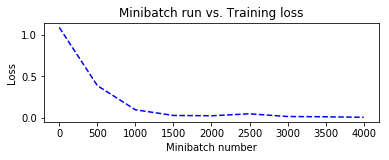

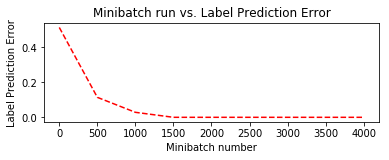

In [15]:

initializeVariables(1, 3, 100, 150)

# Create the model
cz = create_model(cx)

# Number of parameters in the network
C.logging.log_number_of_parameters(cz)

train_and_test("./train-bw-shapes-idx.txt", "./test-bw-shapes-idx.txt")

# Save the model to a file
cz.save("./bw-3shapes-img.dnn")

plotCharts()

### Evaluate the model

Evaluate the model against the test dataset as well as against an individual image

In [20]:
loadAndEvalModel("./bw-3shapes-img.dnn", "./test-bw-shapes-idx.txt", eval_minibatch_size = 3000)

Number of errors: 20
Error % = 0.6666666666666666


In [25]:
print(evaluateImage("./test-bw-shapes-dataset/1.png"))

1


### Train and evaluate model for grayscale images

Similar to the model for black & white images, lets now train a model using grayscale images and then evaluate it using the grayscale test image dataset as well as the black & white test image dataset

Training 4579 parameters in 6 parameter tensors.
Training minibatch size = 55
Number of samples per sweep = 15000
Number of sweeps to train with = 25
Learning rate = 0.1
Number of mini batches to train = 6818.181818181818
Minibatch: 0, Loss: 1.0928, Error: 63.64%, Time since start: 0.6
Minibatch: 500, Loss: 1.0519, Error: 50.91%, Time since start: 139.5
Minibatch: 1000, Loss: 0.9427, Error: 38.18%, Time since start: 266.4
Minibatch: 1500, Loss: 0.7431, Error: 27.27%, Time since start: 387.8
Minibatch: 2000, Loss: 0.7598, Error: 32.73%, Time since start: 520.3
Minibatch: 2500, Loss: 0.5731, Error: 23.64%, Time since start: 650.1
Minibatch: 3000, Loss: 0.2323, Error: 5.45%, Time since start: 769.3
Minibatch: 3500, Loss: 0.3640, Error: 18.18%, Time since start: 913.0
Minibatch: 4000, Loss: 0.2731, Error: 9.09%, Time since start: 1040.5
Minibatch: 4500, Loss: 0.2838, Error: 12.73%, Time since start: 1164.5
Minibatch: 5000, Loss: 0.3421, Error: 10.91%, Time since start: 1285.7
Minibatch: 55

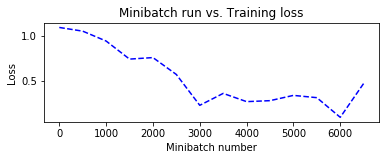

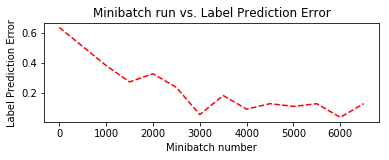

In [28]:

initializeVariables(1, 3, 100, 150)

# Create the model
cz = create_model(cx)

# Number of parameters in the network
C.logging.log_number_of_parameters(cz)

train_and_test("./train-gs-shapes-idx.txt", "./test-gs-shapes-idx.txt", train_minibatch_size = 55, 
               num_samples_per_sweep = 15000, num_sweeps_to_train_with = 25, learning_rate = 0.1)

# Save the model to a file
cz.save("./gs-3shapes-img.dnn")

plotCharts()

In [29]:
loadAndEvalModel("./gs-3shapes-img.dnn", "./test-gs-shapes-idx.txt", eval_minibatch_size = 3000)

Number of errors: 189
Error % = 6.3


In [30]:
loadAndEvalModel("./gs-3shapes-img.dnn", "./test-bw-shapes-idx.txt", eval_minibatch_size = 3000)

Number of errors: 68
Error % = 2.2666666666666666


### Train and evaluate model for grayscale images

Now lets train a model using RGB images and then evaluate it.

Training 4979 parameters in 6 parameter tensors.
Training minibatch size = 35
Number of samples per sweep = 15000
Number of sweeps to train with = 25
Learning rate = 0.1
Number of mini batches to train = 10714.285714285714
Minibatch: 0, Loss: 1.1099, Error: 65.71%, Time since start: 0.6
Minibatch: 500, Loss: 0.9846, Error: 57.14%, Time since start: 164.2
Minibatch: 1000, Loss: 0.8986, Error: 45.71%, Time since start: 304.2
Minibatch: 1500, Loss: 0.6756, Error: 28.57%, Time since start: 437.4
Minibatch: 2000, Loss: 0.3871, Error: 14.29%, Time since start: 569.4
Minibatch: 2500, Loss: 1.0726, Error: 65.71%, Time since start: 712.7
Minibatch: 3000, Loss: 0.8552, Error: 34.29%, Time since start: 864.7
Minibatch: 3500, Loss: 0.6342, Error: 20.00%, Time since start: 1017.7
Minibatch: 4000, Loss: 0.9958, Error: 54.29%, Time since start: 1172.4
Minibatch: 4500, Loss: 0.7152, Error: 28.57%, Time since start: 1320.1
Minibatch: 5000, Loss: 0.4803, Error: 11.43%, Time since start: 1461.8
Minibatch

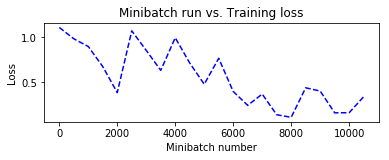

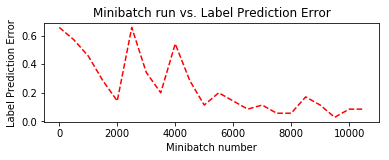

In [31]:
initializeVariables(3, 3, 100, 150)

# Create the model
cz = create_model(cx)

# Number of parameters in the network
C.logging.log_number_of_parameters(cz)

train_and_test("./train-rgb-shapes-idx.txt", "./test-rgb-shapes-idx.txt", train_minibatch_size = 35, 
               num_samples_per_sweep = 15000, num_sweeps_to_train_with = 25, learning_rate = 0.1)

# Save the model to a file
cz.save("./rgb-3shapes-img.dnn")

plotCharts()

In [32]:
loadAndEvalModel("./rgb-3shapes-img.dnn", "./test-rgb-shapes-idx.txt", eval_minibatch_size = 3000)

Number of errors: 327
Error % = 10.9


### Training with a bigger dataset

The error seems to have increased with the RGB dataset and so let's rerun the training cycle with a bigger dataset and see if it yields any difference

Training 4979 parameters in 6 parameter tensors.
Training minibatch size = 35
Number of samples per sweep = 30000
Number of sweeps to train with = 25
Learning rate = 0.1
Number of mini batches to train = 21428.571428571428
Minibatch: 0, Loss: 1.1117, Error: 65.71%, Time since start: 0.6
Minibatch: 500, Loss: 1.0673, Error: 48.57%, Time since start: 180.9
Minibatch: 1000, Loss: 0.7443, Error: 28.57%, Time since start: 312.0
Minibatch: 1500, Loss: 0.7124, Error: 28.57%, Time since start: 446.9
Minibatch: 2000, Loss: 0.6021, Error: 14.29%, Time since start: 595.6
Minibatch: 2500, Loss: 0.5315, Error: 11.43%, Time since start: 784.5
Minibatch: 3000, Loss: 0.2214, Error: 5.71%, Time since start: 975.6
Minibatch: 3500, Loss: 0.2122, Error: 8.57%, Time since start: 1166.3
Minibatch: 4000, Loss: 0.6019, Error: 22.86%, Time since start: 1360.5
Minibatch: 4500, Loss: 0.1718, Error: 5.71%, Time since start: 1542.6
Minibatch: 5000, Loss: 0.1720, Error: 5.71%, Time since start: 1717.0
Minibatch: 55

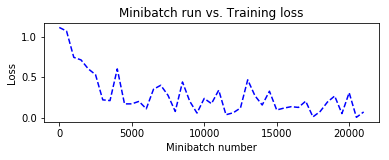

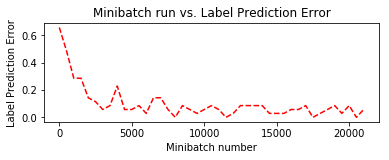

In [33]:
initializeVariables(3, 3, 100, 150)

# Create the model
cz = create_model(cx)

# Number of parameters in the network
C.logging.log_number_of_parameters(cz)

train_and_test("./train-rgb-shapes-idx.txt", "./test-rgb-shapes-idx.txt", train_minibatch_size = 35, 
               num_samples_per_sweep = 30000, num_sweeps_to_train_with = 25, learning_rate = 0.1)

# Save the model to a file
cz.save("./rgb-3shapes-img-2.dnn")

plotCharts()